<a href="https://colab.research.google.com/github/lerguy777/Intention_Tracker_WebApp/blob/main/Copy_of_detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu125

!pip install 'git+https://github.com/facebookresearch/detectron2.git'

import torch, detectron2
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

from detectron2.utils.logger import setup_logger
setup_logger()
print("Detectron2 installed successfully!")


Looking in indexes: https://download.pytorch.org/whl/cu125
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-imyqkogp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-imyqkogp
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Combined

In [ ]:
import sys
import os
import cv2
import torch
import numpy as np
import math
import time
from PIL import Image
from torchvision import transforms
from collections import deque
from scipy.spatial.distance import cdist

# --- Detectron2 Imports ---
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.structures import Instances

# ==============================================================================
# 1. CONFIGURATION PARAMETERS
# ==============================================================================

# ---- Input/Output Configuration ----
root = "/content/drive/MyDrive/colab_projects/keypoint_analysis/"
src_path = root + "input.mp4"
out_path = root + "input-processed.mp4"

# ---- Processing Parameters ----
max_frames = None # Set to None to process entire video
process_every_nth_frame = 1
smoothing_window_size = 10 # Frames for speed averaging
forecast_time_s = 1 # Forecast 1 seconds into the future
person_confidence_threshold = 0.7 # Confidence threshold for person detection (0.0 to 1.0)

# --- Check if the file exists on disk ---
if not os.path.isfile(src_path):
    print(f"Error: Input video file not found at the specified path: {src_path}")
    exit()

# ==============================================================================
# 2. SETUP ROAD SEGMENTATION MODEL (BiSeNetV2)
# ==============================================================================
print("Setting up BiSeNetV2 for road segmentation...")

# Make sure we can import from the repo
repo = "/content/BiSeNet"
if not os.path.isdir(repo):
    print("Cloning BiSeNetV2 repository...")
    # This command needs to be executed in a shell context in Colab
    # In a real script, you'd use subprocess.run(['git', 'clone', '...'])
    # For Colab, a direct `!` prefix usually works.
    !git clone https://github.com/CoinCheung/BiSeNet.git
assert os.path.isdir(repo), "BiSeNet repo folder not found."
sys.path.append(repo)

# BiSeNetV2 model class
from lib.models.bisenetv2 import BiSeNetV2

# Build model & load weights
n_classes = 19
weight_path = os.path.join(repo, "res/model_final_v2_city.pth")
assert os.path.isfile(weight_path), f"Missing weights at {weight_path}"

road_segmentation_net = BiSeNetV2(n_classes=n_classes)
sd = torch.load(weight_path, map_location="cpu")
road_segmentation_net.load_state_dict(sd, strict=True)
road_segmentation_net.eval().cuda()
print("BiSeNetV2 model loaded successfully.")

# --- Helper Functions for Road Segmentation ---
to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.3257, 0.3690, 0.3223), std=(0.2112, 0.2148, 0.2115))
])

def _pad_to_multiple(img_bgr, multiple=32, mode=cv2.BORDER_REFLECT_101):
    h, w = img_bgr.shape[:2]
    th = int(math.ceil(h / multiple) * multiple)
    tw = int(math.ceil(w / multiple) * multiple)
    pad_bottom = th - h
    pad_right  = tw - w
    if pad_bottom == 0 and pad_right == 0:
        return img_bgr, (0, 0, 0, 0)
    padded = cv2.copyMakeBorder(img_bgr, 0, pad_bottom, 0, pad_right, mode)
    return padded, (0, pad_bottom, 0, pad_right)

def infer_logits(img_bgr, net):
    h0, w0 = img_bgr.shape[:2]
    img_pad, (pt, pb, pl, pr) = _pad_to_multiple(img_bgr, 32)
    hp, wp = img_pad.shape[:2]
    img_rgb = cv2.cvtColor(img_pad, cv2.COLOR_BGR2RGB)
    im = Image.fromarray(img_rgb)
    im_tensor = to_tensor(im).unsqueeze(0).cuda()

    with torch.no_grad():
        out = net(im_tensor)
        logits = out[0] if isinstance(out, (list, tuple)) else out
        logits = torch.nn.functional.interpolate(
            logits, size=(hp, wp), mode="bilinear", align_corners=False
        )
        logits = logits[:, :, :h0, :w0]
    return logits.squeeze(0).cpu()

def road_mask_from_logits(logits, threshold=0.5):
    probs = torch.softmax(logits, dim=0)[0].numpy() # road prob = channel 0
    mask = probs > float(threshold)
    return mask.astype(np.uint8)

def draw_road_outline(img_bgr, mask, color=(0, 0, 255), thickness=2): # BGR for red
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output_frame = img_bgr.copy()
    cv2.drawContours(output_frame, contours, -1, color, thickness)
    return output_frame

def is_point_in_mask(point_coords, mask_2d):
    x, y = int(point_coords[0]), int(point_coords[1])
    h, w = mask_2d.shape
    if 0 <= x < w and 0 <= y < h:
        return mask_2d[y, x] == 1
    return False

# ==============================================================================
# 3. SETUP KEYPOINT DETECTION MODEL (Detectron2)
# ==============================================================================
print("\nSetting up Detectron2 for keypoint detection...")
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
)
# Use the confidence threshold variable defined at the top
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = person_confidence_threshold
cfg.MODEL.DEVICE = "cuda"
keypoint_predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
print("Detectron2 model loaded successfully.")

# ==============================================================================
# 4. COMBINED VIDEO PROCESSING
# ==============================================================================
print("\nStarting combined video processing...")

cap = cv2.VideoCapture(src_path)
if not cap.isOpened():
    print(f"Error: Could not open source video: {src_path}")
    exit()

# ---- Video Properties ----
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(out_path, fourcc, fps, (W, H))

# ---- Tracking Data Initialization ----
tracked_people = {}
next_person_id = 0
time_delta = process_every_nth_frame / fps

t0 = time.time()
frame_idx = 0
frames_processed = 0
print(f"Processing every {process_every_nth_frame}th frame, up to {max_frames or 'the end'} frames.")

try:
    while True:
        if max_frames is not None and frame_idx >= max_frames:
            print(f"Reached max frame limit of {max_frames}.")
            break

        ok, frame_bgr = cap.read()
        if not ok:
            break

        frame_idx += 1

        if frame_idx % process_every_nth_frame != 0:
            writer.write(frame_bgr)
            continue

        # --- STEP 1: Apply Road Segmentation Outline ---
        logits = infer_logits(frame_bgr, road_segmentation_net)
        road_mask_2d = road_mask_from_logits(logits, threshold=0.5)
        frame_with_road_outline = draw_road_outline(frame_bgr, road_mask_2d, color=(0, 0, 255), thickness=2)

        # --- STEP 2: Run Keypoint Detection on the new frame ---
        outputs = keypoint_predictor(frame_with_road_outline)
        instances = outputs["instances"].to("cpu")
        frames_processed += 1

        # --- STEP 3: Tracking Logic ---
        current_detections = []
        if instances.has("pred_keypoints") and instances.has("pred_boxes"):
            keypoints = instances.pred_keypoints
            boxes = instances.pred_boxes.tensor.numpy()
            for i, person_kps in enumerate(keypoints):
                left_hip, right_hip = person_kps[11], person_kps[12]
                center_x = (left_hip[0] + right_hip[0]) / 2
                center_y = (left_hip[1] + right_hip[1]) / 2
                current_detections.append({
                    'center': np.array([center_x, center_y]),
                    'keypoints': person_kps,
                    'box': boxes[i]
                })

        unmatched_detections = list(range(len(current_detections)))
        if tracked_people:
            prev_ids = list(tracked_people.keys())
            prev_positions = [p['last_pos'] for p in tracked_people.values()]

            if current_detections and prev_positions:
                current_centers = [d['center'] for d in current_detections]
                distances = cdist(np.array(current_centers), np.array(prev_positions))
                for _ in range(len(current_detections)):
                    if distances.size == 0 or np.min(distances) > 50:
                        break
                    det_idx, prev_idx = np.unravel_index(np.argmin(distances), distances.shape)
                    person_id = prev_ids[prev_idx]
                    detection = current_detections[det_idx]
                    dist_moved = np.linalg.norm(detection['center'] - tracked_people[person_id]['last_pos'])
                    speed_pps = dist_moved / time_delta
                    tracked_people[person_id]['speeds'].append(speed_pps)
                    if dist_moved > 0.1:
                        direction = (detection['center'] - tracked_people[person_id]['last_pos']) / dist_moved
                        tracked_people[person_id]['directions'].append(direction)
                    tracked_people[person_id]['last_pos'] = detection['center']
                    tracked_people[person_id]['keypoints'] = detection['keypoints']
                    tracked_people[person_id]['box'] = detection['box']
                    if det_idx in unmatched_detections:
                        unmatched_detections.remove(det_idx)
                    distances[det_idx, :], distances[:, prev_idx] = np.inf, np.inf

        for det_idx in unmatched_detections:
            detection = current_detections[det_idx]
            tracked_people[next_person_id] = {
                'last_pos': detection['center'],
                'speeds': deque(maxlen=smoothing_window_size),
                'directions': deque(maxlen=smoothing_window_size),
                'keypoints': detection['keypoints'],
                'box': detection['box']
            }
            next_person_id += 1

        # --- STEP 4: Visualization ---
        v = Visualizer(frame_with_road_outline[:, :, ::-1], metadata=metadata, scale=1.0)
        vis_instances = Instances(image_size=(H, W))
        if instances.has("pred_keypoints"):
            vis_instances.pred_keypoints = instances.pred_keypoints
        out = v.draw_instance_predictions(vis_instances)
        final_frame_rgb = out.get_image()

        # ***** FIX WAS HERE *****
        final_frame_bgr = cv2.cvtColor(final_frame_rgb, cv2.COLOR_RGB2BGR)

        for person_id, data in tracked_people.items():
            if 'keypoints' not in data or 'box' not in data: continue

            smoothed_speed = np.mean(data['speeds']) if data['speeds'] else 0

            # --- Draw Speed Text ---
            pos = data['last_pos']
            text = f"{smoothed_speed:.1f} pps"
            cv2.putText(final_frame_bgr, text, (int(pos[0]), int(pos[1] - 25)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            # --- Check current and forecasted positions ---
            draw_red_box = is_point_in_mask(data['last_pos'], road_mask_2d)
            if not draw_red_box and smoothed_speed > 5 and len(data['directions']) > 0:
                avg_direction = np.mean(data['directions'], axis=0)
                norm = np.linalg.norm(avg_direction)
                if norm > 0:
                    avg_direction /= norm
                    forecasted_pos = data['last_pos'] + avg_direction * smoothed_speed * forecast_time_s
                    if is_point_in_mask(forecasted_pos, road_mask_2d):
                        draw_red_box = True

            # --- Draw Red Bounding Box if condition met ---
            if draw_red_box:
                box = data['box']
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(final_frame_bgr, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # --- STEP 5: Write Final Frame ---
        writer.write(final_frame_bgr)

finally:
    cap.release()
    writer.release()
    cv2.destroyAllWindows()
    print(f"\nDone. Processed {frames_processed} frames and wrote to {out_path} in {time.time()-t0:.1f}s")

Setting up BiSeNetV2 for road segmentation...
BiSeNetV2 model loaded successfully.

Setting up Detectron2 for keypoint detection...
Detectron2 model loaded successfully.

Starting combined video processing...
Processing every 1th frame, up to the end frames.


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# road detection - detectron2

road detection - detectron2


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
import requests
from io import BytesIO
from PIL import Image

from tqdm import tqdm


In [ ]:
# Build predictor for COCO Panoptic Segmentation (Panoptic FPN, R50, 3x schedule)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"
))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"
)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.DEVICE = "cuda" if cv2.cuda.getCudaEnabledDeviceCount() > 0 else "cpu"

cfg.INPUT.MIN_SIZE_TEST = 720  # shorter side will be resized to ~720 px
cfg.INPUT.MAX_SIZE_TEST = 1280 # long side clamp; adjust for speed/quality tradeoff

predictor = DefaultPredictor(cfg)

stuff_classes = list(getattr(MetadataCatalog.get("coco_2017_val_panoptic_separated"), "stuff_classes"))


[09/28 05:01:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_50_3x/139514569/model_final_c10459.pkl ...


model_final_c10459.pkl: 184MB [00:01, 162MB/s]                           


In [ ]:
import cv2
import time
import numpy as np
from tqdm.notebook import tqdm
import os

# ---- Setup: Ensure Detectron2 and other libraries are installed ----
# You would typically run the installation commands in a separate cell first.
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu125
# !pip install 'git+https://github.com/facebookresearch/detectron2.git'

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog

# ---- 1. Build Panoptic Segmentation Predictor ----
print("Setting up the Panoptic Segmentation model...")
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"
))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"
)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.DEVICE = "cuda"  # or "cpu"
predictor = DefaultPredictor(cfg)

# Get metadata for class names
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
stuff_classes = metadata.stuff_classes
ROAD_IDX = stuff_classes.index("road")
print("Model setup complete.")

# ---- 2. Configuration ----
# Input video path
input_path = "/content/drive/MyDrive/colab_projects/keypoint_analysis/pedestrian-footage/walking-parallel-1.mp4"

# Output video path
output_folder = "/content/drive/MyDrive/colab_projects/keypoint_analysis/"
output_path = os.path.join(output_folder, "road_overlay.mp4")

# Maximum number of frames to process. Set to None to process the entire video.
max_frames = 40

# ---- 3. Video Processing ----
print(f"Opening video: {input_path}")
cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    print(f"Error: Could not open video file: {input_path}")
    exit()

# Video properties
src_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
src_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fourcc = cv2.VideoWriter_fourcc(*"mp4v")

# Determine the number of frames to process
process_limit = total_frames
if max_frames is not None:
    process_limit = min(total_frames, max_frames)
    print(f"Processing a maximum of {max_frames} frames.")

# Video writer for the output
out_writer = cv2.VideoWriter(output_path, fourcc, fps, (src_w, src_h))

frame_idx = 0

try:
    with tqdm(total=process_limit, desc="Processing Frames") as pbar:
        while True:
            ok, frame_bgr = cap.read()
            if not ok or (max_frames is not None and frame_idx >= max_frames):
                break

            # Run panoptic segmentation
            outputs = predictor(frame_bgr)
            panoptic_seg, segments_info = outputs["panoptic_seg"]
            panoptic_np = panoptic_seg.cpu().numpy()

            # Create a mask for the road
            road_mask = np.zeros(panoptic_np.shape, dtype=np.uint8)
            for seg in segments_info:
                # 'isthing' is False for background stuff like roads, sky, etc.
                if seg.get("isthing", False):
                    continue
                if seg["category_id"] == ROAD_IDX:
                    road_mask[panoptic_np == seg["id"]] = 255

            # Create the overlay
            overlay = frame_bgr.copy()
            alpha = 0.5
            green = np.array([0, 255, 0], dtype=np.uint8) # BGR format
            road_pixels = road_mask > 0

            # Apply green overlay only on the road pixels
            overlay[road_pixels] = (overlay[road_pixels] * (1 - alpha) + green * alpha).astype(np.uint8)

            # Write the frame with the overlay to the output video
            out_writer.write(overlay)

            frame_idx += 1
            pbar.update(1)
finally:
    # Release all resources
    cap.release()
    out_writer.release()
    print("\nProcessing finished.")
    print(f"Saved output video to: {output_path}")


Setting up the Panoptic Segmentation model...
[09/28 05:08:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...
Model setup complete.
Opening video: /content/drive/MyDrive/colab_projects/keypoint_analysis/pedestrian-footage/walking-parallel-1.mp4
Processing a maximum of 40 frames.


Processing Frames:   0%|          | 0/40 [00:00<?, ?it/s]


Processing finished.
Saved output video to: /content/drive/MyDrive/colab_projects/keypoint_analysis/road_overlay.mp4


# bisenetv2

In [ ]:
# Check GPU
!nvidia-smi

# Basic deps
!pip -q install opencv-python tqdm yacs

# Clone BiSeNet (V1 & V2 implementation with demos)
!git clone -q https://github.com/CoinCheung/BiSeNet.git
%cd BiSeNet


Sun Sep 28 05:22:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             33W /   70W |    2594MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# make sure we're inside the BiSeNet repo
%cd /content/BiSeNet

# create res/ if it doesn't exist
!mkdir -p res

# download BiSeNet V2 (Cityscapes) pretrained weights
!wget -O res/model_final_v2_city.pth https://github.com/CoinCheung/BiSeNet/releases/download/0.0.0/model_final_v2_city.pth

# confirm it's there
!ls -lh res/


/content/BiSeNet
--2025-09-28 05:23:36--  https://github.com/CoinCheung/BiSeNet/releases/download/0.0.0/model_final_v2_city.pth
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/159607436/44d72a80-df58-11eb-9f44-83fbc9af2fd6?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-28T06%3A18%3A28Z&rscd=attachment%3B+filename%3Dmodel_final_v2_city.pth&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-28T05%3A17%3A49Z&ske=2025-09-28T06%3A18%3A28Z&sks=b&skv=2018-11-09&sig=Js7sno1bQfxhB07bfxsdUGT%2F9vF%2FTNojM35K5OYx0eg%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1OTAzNzMxNiwibmJmIjoxNzU5MDM3MDE2LCJwYXRoIjo

In [ ]:
import sys, os, cv2, torch, numpy as np
from PIL import Image
from torchvision import transforms

# --- keep your existing net / weights setup ---
# net = BiSeNetV2(...); net.load_state_dict(...); net.eval().cuda()

# make sure we can import from the repo
repo = "/content/BiSeNet"
assert os.path.isdir(repo), "BiSeNet repo folder not found. Did you run the git clone cell?"
sys.path.append(repo)

# BiSeNetV2 model class
from lib.models.bisenetv2 import BiSeNetV2  # this module exists in the repo

# --- Build model & load weights (no lib.utils needed) ---
n_classes = 19
weight_path = os.path.join(repo, "res/model_final_v2_city.pth")
assert os.path.isfile(weight_path), f"Missing weights at {weight_path}"

net = BiSeNetV2(n_classes=n_classes)
sd = torch.load(weight_path, map_location="cpu")
net.load_state_dict(sd, strict=True)
net.eval().cuda()

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.3257, 0.3690, 0.3223), std=(0.2112, 0.2148, 0.2115))
])

def _pad_to_multiple(img_bgr, multiple=32, mode=cv2.BORDER_REFLECT_101):
    """Pad bottom/right so H and W are multiples of `multiple`."""
    h, w = img_bgr.shape[:2]
    th = int(math.ceil(h / multiple) * multiple)
    tw = int(math.ceil(w / multiple) * multiple)
    pad_bottom = th - h
    pad_right  = tw - w
    if pad_bottom == 0 and pad_right == 0:
        return img_bgr, (0, 0, 0, 0)
    padded = cv2.copyMakeBorder(img_bgr, 0, pad_bottom, 0, pad_right, mode)
    return padded, (0, pad_bottom, 0, pad_right)

def infer_logits(img_bgr):
    """
    Pads to multiple-of-32 before forward().
    Returns per-class logits [C, H, W] cropped back to original size.
    """
    h0, w0 = img_bgr.shape[:2]
    img_pad, (pt, pb, pl, pr) = _pad_to_multiple(img_bgr, 32)
    hp, wp = img_pad.shape[:2]

    # to tensor
    img_rgb = cv2.cvtColor(img_pad, cv2.COLOR_BGR2RGB)
    im = Image.fromarray(img_rgb)
    im_tensor = to_tensor(im).unsqueeze(0).cuda()

    with torch.no_grad():
        out = net(im_tensor)
        if isinstance(out, (list, tuple)):
            logits = out[0]
        elif isinstance(out, dict) and "out" in out:
            logits = out["out"]
        else:
            logits = out  # [B,C,h,w]
        # upsample to padded size then crop back to original
        logits = torch.nn.functional.interpolate(
            logits, size=(hp, wp), mode="bilinear", align_corners=False
        )
        logits = logits[:, :, :h0, :w0]  # crop off the pad

    return logits.squeeze(0).cpu()  # [C,H,W]

def road_mask_from_logits(logits, threshold=None):
    ROAD_IDS = {0}  # add 7 if your weights use raw Cityscapes ids
    if threshold is None:
        pred = logits.argmax(0).numpy().astype(np.uint8)
        mask = np.isin(pred, list(ROAD_IDS))
    else:
        probs = torch.softmax(logits, dim=0)[0].numpy()  # road prob = channel 0
        mask = probs > float(threshold)
    return mask.astype(np.uint8)

def overlay_road(img_bgr, mask, alpha=0.5):
    overlay = img_bgr.copy()
    overlay[mask == 1] = (0, 255, 0)
    return cv2.addWeighted(overlay, alpha, img_bgr, 1 - alpha, 0)

# --- Video loop that uses the padded inference ---
def process_video(src="video.mp4", dst="road_overlay.mp4", save_mask=False, prob_thresh=0.5):
    cap = cv2.VideoCapture(src)
    assert cap.isOpened(), f"Could not open {src}"
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out_overlay = cv2.VideoWriter(dst, fourcc, fps, (w, h))
    out_mask = None
    if save_mask:
        out_mask = cv2.VideoWriter("road_mask_video.mp4", fourcc, fps, (w, h), True)

    with torch.no_grad():
        while True:
            ret, frame = cap.read()
            if not ret: break
            logits = infer_logits(frame)
            mask = road_mask_from_logits(logits, threshold=prob_thresh)
            overlay = overlay_road(frame, mask, alpha=0.5)
            out_overlay.write(overlay)
            if out_mask is not None:
                out_mask.write(cv2.cvtColor((mask*255).astype(np.uint8), cv2.COLOR_GRAY2BGR))

    cap.release()
    out_overlay.release()
    if out_mask is not None: out_mask.release()
    print(f"Saved {dst}" + (" and road_mask_video.mp4" if save_mask else ""))

Downloading: "https://github.com/CoinCheung/BiSeNet/releases/download/0.0.0/backbone_v2.pth" to /root/.cache/torch/hub/checkpoints/backbone_v2.pth


100%|██████████| 8.34M/8.34M [00:00<00:00, 64.4MB/s]


In [ ]:
# process_video("walking-parallel-1.mp4", "road_overlay.mp4", save_mask=False)
process_video("/content/drive/MyDrive/colab_projects/keypoint_analysis/pedestrian-footage/walking-parallel-1.mp4",
              "/content/drive/MyDrive/colab_projects/keypoint_analysis/road_overlay.mp4",
              save_mask=False)


Saved /content/drive/MyDrive/colab_projects/keypoint_analysis/road_overlay.mp4


# Movement Analysis

Speed math

In [ ]:
import cv2
import time
import numpy as np
from collections import deque
from scipy.spatial.distance import cdist
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.structures import Instances
from google.colab.patches import cv2_imshow

# ---- Build predictor (same as your image code) ----
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# Use "cpu" if you don't have a GPU setup
cfg.MODEL.DEVICE = "cuda"
predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

# ---- Open a video: replace with 0 for webcam, or a path to your video file ----
# Note: Ensure the path to your video is correct for your Colab environment.
# src = "/content/drive/MyDrive/colab_projects/keypoint_analysis/input.mp4"
src = "/content/drive/MyDrive/colab_projects/keypoint_analysis/road_overlay.mp4"
cap = cv2.VideoCapture(src)
if not cap.isOpened():
    print(f"Error: Could not open source: {src}")
    exit()

# Get original video properties (width/height/fps)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

# ---- Writer for output video ----
out_path = "/content/drive/MyDrive/colab_projects/keypoint_analysis/overlay_speed_v2.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(out_path, fourcc, fps, (W, H))

# ---- Frame processing limit ----
# Set the maximum number of frames to process.
# Set to None to process the entire video.
max_frames = 40

# ---- Frame skipping configuration ----
# Process only every Nth frame to speed up processing. Set to 1 to process all frames.
process_every_nth_frame = 1
time_delta = process_every_nth_frame / fps

# ---- Speed Smoothing Configuration ----
# The number of recent speed readings to average over.
smoothing_window_size = 10

# ---- Tracking Data ----
tracked_people = {}
next_person_id = 0

t0 = time.time()
frame_idx = 0
frames_processed = 0
print(f"Processing every {process_every_nth_frame}th frame, up to {max_frames or 'the end'} frames.")

try:
    while True:
        # Stop if the frame limit is reached
        if max_frames is not None and frame_idx >= max_frames:
            print(f"Reached max frame limit of {max_frames}.")
            break

        ok, frame_bgr = cap.read()
        if not ok:
            break

        frame_idx += 1

        if frame_idx % process_every_nth_frame != 0:
            writer.write(frame_bgr)
            continue

        outputs = predictor(frame_bgr)
        instances = outputs["instances"].to("cpu")
        frames_processed += 1

        # --- Get current detections ---
        current_detections = []
        if instances.has("pred_keypoints"):
            keypoints = instances.pred_keypoints
            for person_kps in keypoints:
                # Use mid-hip as the tracking point
                left_hip = person_kps[11]
                right_hip = person_kps[12]
                center_x = (left_hip[0] + right_hip[0]) / 2
                center_y = (left_hip[1] + right_hip[1]) / 2
                current_detections.append({
                    'center': np.array([center_x, center_y]),
                    'keypoints': person_kps
                })

        # --- Simple distance-based tracking ---
        unmatched_detections = list(range(len(current_detections)))
        if tracked_people:
            prev_ids = list(tracked_people.keys())
            prev_positions = [p['last_pos'] for p in tracked_people.values()]

            if current_detections and prev_positions:
                current_centers = [d['center'] for d in current_detections]
                distances = cdist(np.array(current_centers), np.array(prev_positions))

                # Match detections to tracked people
                for _ in range(len(current_detections)):
                    if distances.size == 0 or np.min(distances) > 50: # Threshold to stop matching
                        break

                    det_idx, prev_idx = np.unravel_index(np.argmin(distances), distances.shape)

                    person_id = prev_ids[prev_idx]
                    detection = current_detections[det_idx]

                    # Calculate speed
                    dist_moved = np.linalg.norm(detection['center'] - tracked_people[person_id]['last_pos'])
                    speed_pps = dist_moved / time_delta

                    tracked_people[person_id]['speeds'].append(speed_pps)
                    tracked_people[person_id]['last_pos'] = detection['center']
                    tracked_people[person_id]['keypoints'] = detection['keypoints'] # Update keypoints

                    if det_idx in unmatched_detections:
                        unmatched_detections.remove(det_idx)

                    distances[det_idx, :] = np.inf
                    distances[:, prev_idx] = np.inf

        # Add any new, unmatched people
        for det_idx in unmatched_detections:
            detection = current_detections[det_idx]
            tracked_people[next_person_id] = {
                'last_pos': detection['center'],
                'speeds': deque(maxlen=smoothing_window_size),
                'keypoints': detection['keypoints']
            }
            next_person_id += 1

        # --- Visualization ---
        # Create a visualizer instance on the frame
        v = Visualizer(frame_bgr[:, :, ::-1], metadata=metadata, scale=1.0)

        # To draw only skeletons, create a new Instances object containing only the keypoints.
        # The main draw_instance_predictions function will then only draw what's available.
        vis_instances = Instances(image_size=(H, W))
        if instances.has("pred_keypoints"):
             vis_instances.pred_keypoints = instances.pred_keypoints

        out = v.draw_instance_predictions(vis_instances)
        frame_with_keypoints = out.get_image()


        # Add speed text and dynamic vector to the frame
        for person_id, data in tracked_people.items():
            if 'keypoints' not in data:
                continue

            # --- Calculate Vector ---
            person_keypoints = data['keypoints']
            left_shoulder = person_keypoints[5]
            right_shoulder = person_keypoints[6]
            left_hip = person_keypoints[11]
            right_hip = person_keypoints[12]

            p1_shoulder = (int(left_shoulder[0]), int(left_shoulder[1]))
            p2_shoulder = (int(right_shoulder[0]), int(right_shoulder[1]))

            mid_shoulder_x = (left_shoulder[0] + right_shoulder[0]) / 2
            mid_shoulder_y = (left_shoulder[1] + right_shoulder[1]) / 2
            mid_hip_x = (left_hip[0] + right_hip[0]) / 2
            mid_hip_y = (left_hip[1] + right_hip[1]) / 2

            p1_torso = (int(mid_hip_x), int(mid_hip_y))
            p2_torso = (int(mid_shoulder_x), int(mid_shoulder_y))

            torso_vec_x = p2_torso[0] - p1_torso[0]
            torso_vec_y = p2_torso[1] - p1_torso[1]

            perp_vec_x, perp_vec_y = -torso_vec_y, torso_vec_x
            norm = np.sqrt(perp_vec_x**2 + perp_vec_y**2)

            if norm > 0:
                perp_vec_x /= norm
                perp_vec_y /= norm

                # --- Scale Vector based on Speed ---
                smoothed_speed = np.mean(data['speeds']) if data['speeds'] else 0

                # Define mapping from speed to vector length
                min_speed, max_speed = 0, 300 # pps
                shoulder_width = np.linalg.norm(np.array(p1_shoulder) - np.array(p2_shoulder))
                min_scale = shoulder_width * 0.25 # Short vector for low speed
                max_scale = shoulder_width * 2.25  # Long vector for high speed (1.5 * 1.5)

                speed_ratio = min(1.0, max(0.0, (smoothed_speed - min_speed) / (max_speed - min_speed)))
                scale_factor = min_scale + speed_ratio * (max_scale - min_scale)

                # --- Draw Vector ---
                mid_torso_x = (p1_torso[0] + p2_torso[0]) / 2
                mid_torso_y = (p1_torso[1] + p2_torso[1]) / 2
                p1_cross = (int(mid_torso_x), int(mid_torso_y))
                p2_cross = (int(mid_torso_x + perp_vec_x * scale_factor), int(mid_torso_y + perp_vec_y * scale_factor))

                # Draw the bright green vector with a thickness of 2
                cv2.arrowedLine(frame_with_keypoints, p1_cross, p2_cross, (0, 255, 0), thickness=2, tipLength=0.2)

                # --- Draw Speed Text ---
                pos = data['last_pos']
                text = f"{smoothed_speed:.1f} pps"
                cv2.putText(frame_with_keypoints, text, (int(pos[0]), int(pos[1] - 25)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        frame_bgr_overlay = frame_with_keypoints[:, :, ::-1]
        writer.write(frame_bgr_overlay)

finally:
    cap.release()
    writer.release()
    cv2.destroyAllWindows()

print(f"Done. Processed {frames_processed} frames and wrote to {out_path} in {time.time()-t0:.1f}s")

[09/28 05:17:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...
Processing every 1th frame, up to 40 frames.
Reached max frame limit of 40.
Done. Processed 40 frames and wrote to /content/drive/MyDrive/colab_projects/keypoint_analysis/overlay_speed_v2.mp4 in 16.0s


In [ ]:
from IPython.display import Video

video_path = "/content/drive/MyDrive/colab_projects/keypoint_analysis/overlay_speed.mp4"
Video(video_path, embed=True)

# Video Analysis Drafts

New Logic

In [ ]:
import cv2
import time
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

# ---- Build predictor (same as your image code) ----
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# Use "cpu" if you don't have a GPU setup
cfg.MODEL.DEVICE = "cuda"
predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

# ---- Open a video: replace with 0 for webcam, or a path to your video file ----
# Note: Ensure the path to your video is correct for your Colab environment.
src = "/content/drive/MyDrive/input.mp4"
cap = cv2.VideoCapture(src)
if not cap.isOpened():
    print(f"Error: Could not open source: {src}")
    exit()

# Get original video properties (width/height/fps)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

# ---- Writer for output video ----
out_path = "overlay.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(out_path, fourcc, fps, (W, H))

# ---- Frame processing limit ----
# Set the maximum number of frames to process.
# Set to None to process the entire video.
max_frames = None

# ---- Frame skipping configuration ----
# Process only every Nth frame to speed up processing. Set to 1 to process all frames.
process_every_nth_frame = 5

t0 = time.time()
frame_idx = 0
frames_processed = 0
print(f"Processing every {process_every_nth_frame}th frame, up to {max_frames or 'the end'} frames.")

try:
    while True:
        # Stop if the frame limit is reached
        if max_frames is not None and frame_idx >= max_frames:
            print(f"Reached max frame limit of {max_frames}.")
            break

        ok, frame_bgr = cap.read()
        if not ok:
            # End of video
            break

        frame_idx += 1

        # ---- Skip frame if it's not the Nth frame ----
        if frame_idx % process_every_nth_frame != 0:
            # We still need to write the original frame to the output to avoid a choppy video
            writer.write(frame_bgr)
            continue

        # Predict expects BGR (OpenCV default)
        outputs = predictor(frame_bgr)
        instances = outputs["instances"].to("cpu")
        frames_processed += 1

        # Visualizer expects RGB
        v = Visualizer(frame_bgr[:, :, ::-1], metadata=metadata,
                       scale=1.0, instance_mode=ColorMode.IMAGE)
        out = v.draw_instance_predictions(instances)
        frame_rgb = out.get_image()

        # Convert back to BGR for VideoWriter
        frame_bgr_overlay = frame_rgb[:, :, ::-1]
        writer.write(frame_bgr_overlay)

finally:
    # Release resources
    cap.release()
    writer.release()
    cv2.destroyAllWindows()

print(f"Done. Processed {frames_processed} frames (out of {frame_idx} total) and wrote to {out_path} in {time.time()-t0:.1f}s")


New Vector

In [ ]:
import cv2
import time
import numpy as np
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

# ---- Build predictor (same as your image code) ----
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# Use "cpu" if you don't have a GPU setup
cfg.MODEL.DEVICE = "cuda"
predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

# ---- Open a video: replace with 0 for webcam, or a path to your video file ----
# Note: Ensure the path to your video is correct for your Colab environment.
src = "/content/drive/MyDrive/colab_projects/keypoint_analysis/input.mp4"
cap = cv2.VideoCapture(src)
if not cap.isOpened():
    print(f"Error: Could not open source: {src}")
    exit()

# Get original video properties (width/height/fps)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

# ---- Writer for output video ----
out_path = "overlay.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(out_path, fourcc, fps, (W, H))

# ---- Frame processing limit ----
# Set the maximum number of frames to process.
# Set to None to process the entire video.
max_frames = 40

# ---- Frame skipping configuration ----
# Process only every Nth frame to speed up processing. Set to 1 to process all frames.
process_every_nth_frame = 1

t0 = time.time()
frame_idx = 0
frames_processed = 0
print(f"Processing every {process_every_nth_frame}th frame, up to {max_frames or 'the end'} frames.")

try:
    while True:
        # Stop if the frame limit is reached
        if max_frames is not None and frame_idx >= max_frames:
            print(f"Reached max frame limit of {max_frames}.")
            break

        ok, frame_bgr = cap.read()
        if not ok:
            # End of video
            break

        frame_idx += 1

        # ---- Skip frame if it's not the Nth frame ----
        if frame_idx % process_every_nth_frame != 0:
            # We still need to write the original frame to the output to avoid a choppy video
            writer.write(frame_bgr)
            continue

        # Predict expects BGR (OpenCV default)
        outputs = predictor(frame_bgr)
        instances = outputs["instances"].to("cpu")
        frames_processed += 1

        # --- Prepare vectors for drawing ---
        vectors_to_draw = []
        # Check if the model predicted keypoints
        if instances.has("pred_keypoints"):
            keypoints_tensor = instances.pred_keypoints
            # COCO keypoint mapping: 5='left_shoulder', 6='right_shoulder', 11='left_hip', 12='right_hip'
            left_shoulder_idx, right_shoulder_idx = 5, 6
            left_hip_idx, right_hip_idx = 11, 12

            # Iterate through each person detected in the frame
            for person_keypoints in keypoints_tensor:
                # Get the coordinate tensors for each keypoint
                left_shoulder = person_keypoints[left_shoulder_idx]
                right_shoulder = person_keypoints[right_shoulder_idx]
                left_hip = person_keypoints[left_hip_idx]
                right_hip = person_keypoints[right_hip_idx]

                # --- Shoulder Vector (Calculated but not drawn) ---
                p1_shoulder = (int(left_shoulder[0]), int(left_shoulder[1]))
                p2_shoulder = (int(right_shoulder[0]), int(right_shoulder[1]))

                # --- Torso Vector (Calculated but not drawn) ---
                mid_shoulder_x = (left_shoulder[0] + right_shoulder[0]) / 2
                mid_shoulder_y = (left_shoulder[1] + right_shoulder[1]) / 2
                mid_hip_x = (left_hip[0] + right_hip[0]) / 2
                mid_hip_y = (left_hip[1] + right_hip[1]) / 2
                p1_torso = (int(mid_hip_x), int(mid_hip_y))
                p2_torso = (int(mid_shoulder_x), int(mid_shoulder_y))

                # --- "Cross Product" Vector (Perpendicular to Torso) ---
                # Calculate torso vector components
                torso_vec_x = p2_torso[0] - p1_torso[0]
                torso_vec_y = p2_torso[1] - p1_torso[1]

                # Find a perpendicular vector by rotating the torso vector 90 degrees
                perp_vec_x = -torso_vec_y
                perp_vec_y = torso_vec_x

                # Normalize the perpendicular vector
                norm = np.sqrt(perp_vec_x**2 + perp_vec_y**2)
                if norm > 0:
                    perp_vec_x /= norm
                    perp_vec_y /= norm

                    # Scale it based on shoulder width for a consistent appearance
                    shoulder_width = np.sqrt((p2_shoulder[0] - p1_shoulder[0])**2 + (p2_shoulder[1] - p1_shoulder[1])**2)
                    scale_factor = shoulder_width * 0.5 # Make the vector half the shoulder width

                    # Define start point (mid-torso) and end point for the new vector
                    mid_torso_x = (p1_torso[0] + p2_torso[0]) / 2
                    mid_torso_y = (p1_torso[1] + p2_torso[1]) / 2
                    p1_cross = (int(mid_torso_x), int(mid_torso_y))

                    p2_cross_x = mid_torso_x + perp_vec_x * scale_factor
                    p2_cross_y = mid_torso_y + perp_vec_y * scale_factor
                    p2_cross = (int(p2_cross_x), int(p2_cross_y))

                    vectors_to_draw.append((p1_cross, p2_cross, (0, 0, 255))) # Blue for the new vector

        # --- Visualization ---
        # Get the standard keypoint overlay from Visualizer
        v = Visualizer(frame_bgr[:, :, ::-1], metadata=metadata,
                       scale=1.0, instance_mode=ColorMode.IMAGE)
        out = v.draw_instance_predictions(instances)
        frame_with_keypoints = out.get_image() # This is an RGB image

        # Draw the custom vectors on top of the keypoint overlay
        frame_with_vectors = frame_with_keypoints.copy()
        for p1, p2, color in vectors_to_draw:
            cv2.arrowedLine(frame_with_vectors, p1, p2, color, thickness=3, tipLength=0.1)

        # Convert the final image back to BGR for VideoWriter
        frame_bgr_overlay = frame_with_vectors[:, :, ::-1]
        writer.write(frame_bgr_overlay)

finally:
    # Release resources
    cap.release()
    writer.release()
    cv2.destroyAllWindows()

print(f"Done. Processed {frames_processed} frames (out of {frame_idx} total) and wrote to {out_path} in {time.time()-t0:.1f}s")

[09/28 04:52:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...
Processing every 1th frame, up to 40 frames.
Reached max frame limit of 40.
Done. Processed 40 frames (out of 40 total) and wrote to overlay.mp4 in 28.5s


Parallelized Version

In [ ]:
import cv2
import time
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from google.colab.patches import cvto_imshow
import torch

# ---- Build predictor (same as your image code) ----
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# Use "cpu" if you don't have a GPU setup
cfg.MODEL.DEVICE = "cuda"
predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

# ---- Open a video: replace with 0 for webcam, or a path to your video file ----
# Note: Ensure the path to your video is correct for your Colab environment.
src = "/content/drive/MyDrive/input.mp4"
cap = cv2.VideoCapture(src)
if not cap.isOpened():
    print(f"Error: Could not open source: {src}")
    exit()

# Get original video properties (width/height/fps)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

# ---- Writer for output video ----
out_path = "overlay.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(out_path, fourcc, fps, (W, H))

# ---- Frame processing limit ----
# Set the maximum number of frames to process.
# Set to None to process the entire video.
max_frames = 500

# ---- Batch processing configuration ----
# Process frames in batches for faster inference on GPU.
# Adjust batch_size based on your GPU memory.
batch_size = 8

# ---- Helper function for processing a batch of frames ----
def process_batch(batch, predictor, writer, metadata):
    """
    Processes a batch of frames:
    1. Pre-processes each frame using the predictor's augmentation pipeline.
    2. Sends the entire batch to the model for inference.
    3. Visualizes the results and writes frames to the output video.
    """
    # The model expects a list of dicts, each with a preprocessed image tensor.
    # We use the predictor's augmentation pipeline to prepare the images.
    inputs = []
    for frame_bgr in batch:
        # Apply the same pre-processing as DefaultPredictor
        image = predictor.aug.get_transform(frame_bgr).apply_image(frame_bgr)
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs.append({"image": image})

    with torch.no_grad():
        outputs = predictor.model(inputs)

    # Visualize and write each frame from the processed batch
    for i in range(len(batch)):
        frame_bgr = batch[i]
        output = outputs[i]
        instances = output["instances"].to("cpu")
        v = Visualizer(frame_bgr[:, :, ::-1], metadata=metadata,
                       scale=1.0, instance_mode=ColorMode.IMAGE)
        out = v.draw_instance_predictions(instances)
        frame_rgb = out.get_image()
        frame_bgr_overlay = frame_rgb[:, :, ::-1]
        writer.write(frame_bgr_overlay)


t0 = time.time()
frame_idx = 0
print(f"Processing video... up to {max_frames or 'the end'} frames with batch size {batch_size}.")

try:
    frame_batch = []
    while True:
        # Stop if the frame limit is reached
        if max_frames is not None and frame_idx >= max_frames:
            print(f"Reached max frame limit of {max_frames}.")
            break

        ok, frame_bgr = cap.read()
        if not ok:
            # End of video, process any remaining frames in the batch
            if frame_batch:
                process_batch(frame_batch, predictor, writer, metadata)
            break

        frame_batch.append(frame_bgr)
        frame_idx += 1

        # When the batch is full, process it
        if len(frame_batch) == batch_size:
            process_batch(frame_batch, predictor, writer, metadata)
            # Clear the batch to start a new one
            frame_batch.clear()

finally:
    # Release resources
    cap.release()
    writer.release()
    cv2.destroyAllWindows()

print(f"Done. Wrote {frame_idx} frames to {out_path} in {time.time()-t0:.1f}s")


[09/28 02:09:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...
Processing every 5th frame, up to the end frames.
Done. Processed 28 frames (out of 144 total) and wrote to overlay.mp4 in 22.7s


Original

# Single Image

[09/28 01:02:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...


model_final_a6e10b.pkl: 237MB [00:01, 237MB/s]                           
/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


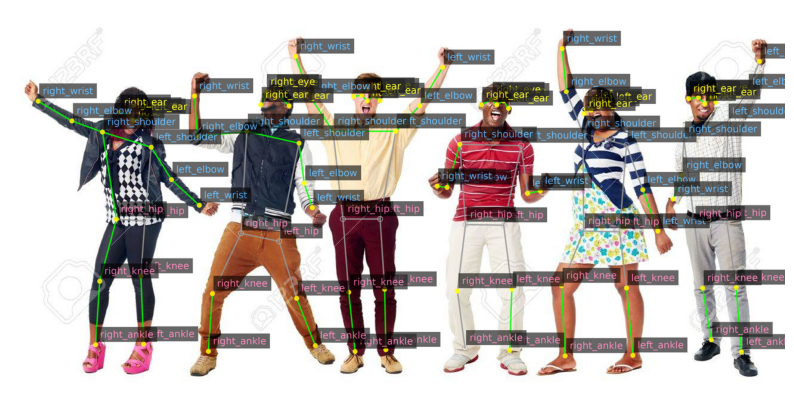

In [ ]:
import cv2, numpy as np, requests, matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog


# Load test image
!wget -q https://previews.123rf.com/images/warrengoldswain/warrengoldswain1308/warrengoldswain130800077/21858507-celebrating-diversity-real-people-group-isolated-on-white-cheering.jpg -O input.jpg
im = cv2.imread("input.jpg")

cfg = get_cfg()
# Use a Detectron2 keypoint model (COCO Keypoints)
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5     # filter low-confidence detections
cfg.MODEL.DEVICE = "cuda"                        # or "cpu" if no GPU
predictor = DefaultPredictor(cfg)

outputs = predictor(im)  # -> dict with "instances"
instances = outputs["instances"].to("cpu")

# Visualize; Visualizer will draw boxes, keypoints, and the skeleton automatically
# v = Visualizer(
#     im[:, :, ::-1],
#     MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
#     scale=1.0,
#     instance_mode=ColorMode.IMAGE
# )
# out = v.draw_instance_predictions(instances)
# plt.imshow(out.get_image()[:, :, ::-1]); plt.axis("off"); plt.show()

from PIL import Image, ImageDraw, ImageFont
from matplotlib import font_manager

# ---- COCO keypoints & skeleton ----
COCO_KEYPOINT_NAMES = [
    "nose","left_eye","right_eye","left_ear","right_ear",
    "left_shoulder","right_shoulder","left_elbow","right_elbow",
    "left_wrist","right_wrist","left_hip","right_hip",
    "left_knee","right_knee","left_ankle","right_ankle"
]
COCO_SKELETON = [
    (0,1),(0,2),(1,3),(2,4),
    (5,6),
    (5,7),(7,9),(6,8),(8,10),
    (5,11),(6,12),(11,12),
    (11,13),(13,15),(12,14),(14,16)
]

# ---- Settings ----
SSAA = 3.0                        # supersample factor (try 2.0–4.0)
dot_radius = 4 * int(SSAA)        # scales with SSAA
line_thickness = max(2, int(2*SSAA))
font_size = int(16 * SSAA)        # bigger base size; PIL will anti-alias
label_pad = int(6 * SSAA)
label_offset = (int(8*SSAA), int(-8*SSAA))
alpha_overlay = 0.85
hi_conf = 0.30

# Colors (RGB for PIL, BGR for cv2 where used)
COL_DOT_HI = (255, 255, 0)   # yellow
COL_DOT_LO = (180, 180, 180)
COL_LINE_HI = (0, 255, 0)    # green (we'll draw with cv2 on BGR canvas first)
COL_LINE_LO = (150, 150, 150)

# Pick a crisp TrueType font (fallback to DejaVu)
try:
    font_path = font_manager.findfont("DejaVu Sans")  # usually present in Colab
except Exception:
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
font = ImageFont.truetype(font_path, size=font_size)

# ---- Prepare supersampled canvas ----
H, W = im.shape[:2]
bigW, bigH = int(W*SSAA), int(H*SSAA)
big_im = cv2.resize(im, (bigW, bigH), interpolation=cv2.INTER_CUBIC)   # BGR
overlay = big_im.copy()

# Scale keypoints
kps = instances.pred_keypoints.numpy() if instances.has("pred_keypoints") else None
if kps is None:
    raise ValueError("No keypoints found in instances.")
kps_big = kps.copy()
kps_big[..., :2] *= SSAA  # scale x,y

# ---- Draw skeleton lines (cv2 for speed) ----
for person in kps_big:
    for a, b in COCO_SKELETON:
        xa, ya, sa = person[a]
        xb, yb, sb = person[b]
        xa, ya = int(np.clip(xa, 0, bigW-1)), int(np.clip(ya, 0, bigH-1))
        xb, yb = int(np.clip(xb, 0, bigW-1)), int(np.clip(yb, 0, bigH-1))
        col = COL_LINE_HI if min(sa, sb) >= hi_conf else COL_LINE_LO
        # cv2 expects BGR
        cv2.line(overlay, (xa, ya), (xb, yb), (col[2], col[1], col[0]), line_thickness, cv2.LINE_AA)

# ---- Draw joints and labels (PIL for high-quality text AA) ----
# Convert to RGB PIL image for text
overlay_pil = Image.fromarray(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(overlay_pil, "RGBA")

def joint_color(name):
    # region-color labels for readability (face/arms/legs)
    if name in {"nose","left_eye","right_eye","left_ear","right_ear"}:
        return (255, 255, 0, 255)   # yellow
    if "shoulder" in name or "elbow" in name or "wrist" in name:
        return (80, 180, 255, 255)  # light blue
    if "hip" in name or "knee" in name or "ankle" in name:
        return (255, 120, 180, 255) # pinkish
    return (220, 220, 220, 255)

for person in kps_big:
    for j, (x, y, s) in enumerate(person):
        x = int(np.clip(x, 0, bigW-1)); y = int(np.clip(y, 0, bigH-1))
        # Dot style
        if s >= hi_conf:
            dot_col = COL_DOT_HI
            # filled circle via cv2 for speed (on BGR; convert later again)
            cv2.circle(overlay, (x, y), dot_radius, (dot_col[2], dot_col[1], dot_col[0]), -1, cv2.LINE_AA)
        else:
            dot_col = COL_DOT_LO
            cv2.circle(overlay, (x, y), dot_radius+1, (dot_col[2], dot_col[1], dot_col[0]), 2, cv2.LINE_AA)

# Re-convert to PIL after drawing dots
overlay_pil = Image.fromarray(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(overlay_pil, "RGBA")

for person in kps_big:
    for j, (x, y, s) in enumerate(person):
        name = COCO_KEYPOINT_NAMES[j]
        text = name  # or f"{name} ({s:.2f})"
        tx = int(x + label_offset[0]); ty = int(y + label_offset[1])

        # Text size
        tw, th = draw.textbbox((0,0), text, font=font)[2:]
        # Background box (semi-transparent black)
        rect = [tx - label_pad, ty - th - label_pad//2, tx + tw + label_pad, ty + label_pad//2]
        # clip
        rect[0] = max(0, rect[0]); rect[1] = max(0, rect[1])
        rect[2] = min(bigW-1, rect[2]); rect[3] = min(bigH-1, rect[3])
        draw.rectangle(rect, fill=(0,0,0,180))

        # Text color by body region; dim if low conf
        base_col = joint_color(name)
        col = base_col if s >= hi_conf else (base_col[0], base_col[1], base_col[2], 200)

        # Draw crisp text
        draw.text((tx, ty - th), text, font=font, fill=col)

# ---- Alpha blend overlay with original supersampled image ----
final_big = Image.fromarray(cv2.cvtColor(big_im, cv2.COLOR_BGR2RGB)).convert("RGBA")
overlay_pil = overlay_pil.convert("RGBA")
blended_big = Image.blend(final_big, overlay_pil, alpha_overlay)

# ---- Downscale back to original size with high-quality filter ----
blended = blended_big.resize((W, H), resample=Image.LANCZOS)

plt.figure(figsize=(10, 10))
plt.imshow(blended)
plt.axis("off")
plt.show()




[09/28 01:33:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...
Shoulder vectors for each person:
Person 1: [-245.08017   -75.934204]
Person 2: [-218.82349  -58.37372]
Person 3: [-315.40674    0.     ]
Person 4: [-263.04163   -58.450012]
Person 5: [-308.86084     -5.8460693]
Person 6: [-218.84717   90.52838]

Torso vectors for each person:
Person 1: [ 18.964478 404.4956  ]
Person 2: [-16.047363 462.61133 ]
Person 3: [-14.602295 440.91394 ]
Person 4: [-64.29907 502.67017]
Person 5: [-29.137695 401.92108 ]
Person 6: [ 24.802734 467.24304 ]


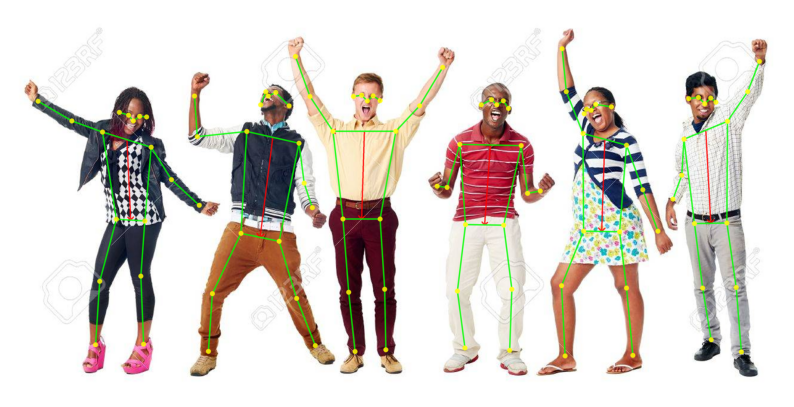

In [ ]:
import cv2, numpy as np, requests, matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog


# Load test image
!wget -q https://previews.123rf.com/images/warrengoldswain/warrengoldswain1308/warrengoldswain130800077/21858507-celebrating-diversity-real-people-group-isolated-on-white-cheering.jpg -O input.jpg
im = cv2.imread("input.jpg")

cfg = get_cfg()
# Use a Detectron2 keypoint model (COCO Keypoints)
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5     # filter low-confidence detections
cfg.MODEL.DEVICE = "cuda"                        # or "cpu" if no GPU
predictor = DefaultPredictor(cfg)

outputs = predictor(im)  # -> dict with "instances"
instances = outputs["instances"].to("cpu")

# Visualize; Visualizer will draw boxes, keypoints, and the skeleton automatically
# v = Visualizer(
#     im[:, :, ::-1],
#     MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
#     scale=1.0,
#     instance_mode=ColorMode.IMAGE
# )
# out = v.draw_instance_predictions(instances)
# plt.imshow(out.get_image()[:, :, ::-1]); plt.axis("off"); plt.show()

from PIL import Image, ImageDraw, ImageFont
from matplotlib import font_manager

# ---- COCO keypoints & skeleton ----
COCO_KEYPOINT_NAMES = [
    "nose","left_eye","right_eye","left_ear","right_ear",
    "left_shoulder","right_shoulder","left_elbow","right_elbow",
    "left_wrist","right_wrist","left_hip","right_hip",
    "left_knee","right_knee","left_ankle","right_ankle"
]
COCO_SKELETON = [
    (0,1),(0,2),(1,3),(2,4),
    (5,6),
    (5,7),(7,9),(6,8),(8,10),
    (5,11),(6,12),(11,12),
    (11,13),(13,15),(12,14),(14,16)
]

# ---- Settings ----
SSAA = 3.0                        # supersample factor (try 2.0–4.0)
dot_radius = 4 * int(SSAA)        # scales with SSAA
line_thickness = max(2, int(2*SSAA))
font_size = int(16 * SSAA)        # bigger base size; PIL will anti-alias
label_pad = int(6 * SSAA)
label_offset = (int(8*SSAA), int(-8*SSAA))
alpha_overlay = 0.85
hi_conf = 0.05

# Colors (RGB for PIL, BGR for cv2 where used)
COL_DOT_HI = (255, 255, 0)   # yellow
COL_DOT_LO = (180, 180, 180)
COL_LINE_HI = (0, 255, 0)    # green (we'll draw with cv2 on BGR canvas first)
COL_LINE_LO = (150, 150, 150)
COL_VECTOR = (255, 0, 0) # Blue color for vectors
COL_ANGLE_TEXT = (255, 255, 255) # White color for angle text


# Pick a crisp TrueType font (fallback to DejaVu)
try:
    font_path = font_manager.findfont("DejaVu Sans")  # usually present in Colab
except Exception:
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
font = ImageFont.truetype(font_path, size=font_size)

# ---- Prepare supersampled canvas ----
H, W = im.shape[:2]
bigW, bigH = int(W*SSAA), int(H*SSAA)
big_im = cv2.resize(im, (bigW, bigH), interpolation=cv2.INTER_CUBIC)   # BGR
overlay = big_im.copy()

# Scale keypoints
kps = instances.pred_keypoints.numpy() if instances.has("pred_keypoints") else None
if kps is None:
    raise ValueError("No keypoints found in instances.")
kps_big = kps.copy()
kps_big[..., :2] *= SSAA  # scale x,y

# Calculate shoulder vectors
shoulder_vectors = []
for person in kps_big:
    # Ensure both left and right shoulders are detected with sufficient confidence
    if person[5][2] >= hi_conf and person[6][2] >= hi_conf:
        left_shoulder = person[5][:2]  # x, y of left shoulder
        right_shoulder = person[6][:2] # x, y of right shoulder
        shoulder_vector = right_shoulder - left_shoulder
        shoulder_vectors.append(shoulder_vector)
    else:
        shoulder_vectors.append(None) # Append None if shoulders are not detected

print("Shoulder vectors for each person:")
for i, vector in enumerate(shoulder_vectors):
    if vector is not None:
        print(f"Person {i+1}: {vector}")
    else:
        print(f"Person {i+1}: Shoulders not detected with sufficient confidence")

# Calculate torso vectors
torso_vectors = []
mid_shoulders = []
for person in kps_big:
    # Ensure both left/right shoulders and left/right hips are detected with sufficient confidence
    if (person[5][2] >= hi_conf and person[6][2] >= hi_conf and
        person[11][2] >= hi_conf and person[12][2] >= hi_conf):

        mid_shoulder_x = (person[5][0] + person[6][0]) / 2
        mid_shoulder_y = (person[5][1] + person[6][1]) / 2
        mid_shoulder = np.array([mid_shoulder_x, mid_shoulder_y])
        mid_shoulders.append(mid_shoulder)

        mid_hip_x = (person[11][0] + person[12][0]) / 2
        mid_hip_y = (person[11][1] + person[12][1]) / 2
        mid_hip = np.array([mid_hip_x, mid_hip_y])

        torso_vector = mid_hip - mid_shoulder
        torso_vectors.append(torso_vector)
    else:
        torso_vectors.append(None) # Append None if required keypoints are not detected
        mid_shoulders.append(None)

print("\nTorso vectors for each person:")
for i, vector in enumerate(torso_vectors):
    if vector is not None:
        print(f"Person {i+1}: {vector}")
    else:
        print(f"Person {i+1}: Required keypoints for torso vector not detected with sufficient confidence")

# Draw torso vectors and calculate/draw angles
for i, person in enumerate(kps_big):
    if torso_vectors[i] is not None:
        # Draw torso vector
        start_point_torso = (int(mid_shoulders[i][0]), int(mid_shoulders[i][1]))
        end_point_torso = (int(mid_shoulders[i][0] + torso_vectors[i][0]), int(mid_shoulders[i][1] + torso_vectors[i][1]))
        cv2.arrowedLine(overlay, start_point_torso, end_point_torso, (COL_VECTOR[2], COL_VECTOR[1], COL_VECTOR[0]), line_thickness, tipLength=0.05)

        # Calculate angle between shoulder and torso vectors
        if shoulder_vectors[i] is not None:
            v1 = shoulder_vectors[i]
            v2 = torso_vectors[i]
            dot_product = np.dot(v1, v2)
            norm_v1 = np.linalg.norm(v1)
            norm_v2 = np.linalg.norm(v2)
            if norm_v1 != 0 and norm_v2 != 0:
                cosine_angle = dot_product / (norm_v1 * norm_v2)
                angle_rad = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
                angle_deg = np.degrees(angle_rad)

                # Draw angle text near the mid-shoulder
                text_pos = (int(mid_shoulders[i][0] + label_offset[0]), int(mid_shoulders[i][1] + label_offset[1]))
                text = f"{angle_deg:.1f} deg"
                 # Use PIL for drawing text
                draw.text(text_pos, text, font=font, fill=COL_ANGLE_TEXT)

    # Draw shoulder vectors as arrows
    if shoulder_vectors[i] is not None:
        start_point_shoulder = (int(person[5][0]), int(person[5][1])) # Left shoulder
        end_point_shoulder = (int(person[6][0]), int(person[6][1])) # Right shoulder
        cv2.arrowedLine(overlay, start_point_shoulder, end_point_shoulder, (COL_VECTOR[2], COL_VECTOR[1], COL_VECTOR[0]), line_thickness, tipLength=0.05)


# ---- Draw skeleton lines (cv2 for speed) ----
for person in kps_big:
    for a, b in COCO_SKELETON:
        xa, ya, sa = person[a]
        xb, yb, sb = person[b]
        xa, ya = int(np.clip(xa, 0, bigW-1)), int(np.clip(ya, 0, bigH-1))
        xb, yb = int(np.clip(xb, 0, bigW-1)), int(np.clip(yb, 0, bigH-1))
        col = COL_LINE_HI if min(sa, sb) >= hi_conf else COL_LINE_LO
        # cv2 expects BGR
        cv2.line(overlay, (xa, ya), (xb, yb), (col[2], col[1], col[0]), line_thickness, cv2.LINE_AA)

# ---- Draw joints (without labels) ----
# Convert to RGB PIL image for drawing dots with alpha
overlay_pil = Image.fromarray(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(overlay_pil, "RGBA")

def joint_color(name):
    # region-color labels for readability (face/arms/legs)
    if name in {"nose","left_eye","right_eye","left_ear","right_ear"}:
        return (255, 255, 0, 255)   # yellow
    if "shoulder" in name or "elbow" in name or "wrist" in name:
        return (80, 180, 255, 255)  # light blue
    if "hip" in name or "knee" in name or "ankle" in name:
        return (255, 120, 180, 255) # pinkish
    return (220, 220, 220, 255)

for person in kps_big:
    for j, (x, y, s) in enumerate(person):
        x = int(np.clip(x, 0, bigW-1)); y = int(np.clip(y, 0, bigH-1))
        # Dot style
        if s >= hi_conf:
            dot_col = COL_DOT_HI
            # filled circle via cv2 for speed (on BGR; convert later again)
            cv2.circle(overlay, (x, y), dot_radius, (dot_col[2], dot_col[1], dot_col[0]), -1, cv2.LINE_AA)
        else:
            dot_col = COL_DOT_LO
            cv2.circle(overlay, (x, y), dot_radius+1, (dot_col[2], dot_col[1], dot_col[0]), 2, cv2.LINE_AA)


# ---- Alpha blend overlay with original supersampled image ----
final_big = Image.fromarray(cv2.cvtColor(big_im, cv2.COLOR_BGR2RGB)).convert("RGBA")
overlay_pil = Image.fromarray(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)).convert("RGBA") # Re-convert overlay to PIL after drawing vectors
blended_big = Image.blend(final_big, overlay_pil, alpha_overlay)

# ---- Downscale back to original size with high-quality filter ----
blended = blended_big.resize((W, H), resample=Image.LANCZOS)

plt.figure(figsize=(10, 10))
plt.imshow(blended)
plt.axis("off")
plt.show()